# Lab 05 : ODE

## Objectives

In this lab we will solve a system of differential equations using `scipy.integrate.solve_ivp`.

Regardless of whether you consider baseball the great American pastime or a bunch of guys standing around watching grass grow, it is the case that there is a lot of interesting physics in baseball.  In this lab we will explore the amazing things a pitcher can do with a baseball.  In doing so we will use `scipy.integrate.solve_ivp` to solve the equation of motion of a spinning baseball.

## Initialization

As always, initialize your environment now by loading all modules required and setting up the plotting environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.interpolate as interp
import scipy.special as sf
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import scipy.integrate as integ

## Baseball Motion

The physics of the motion of a baseball is an interesting study in its own right.  We will not undertake such a study and instead just use the results from the [Numerical Modeling of Baseball Pitching](http://people.kzoo.edu/barth/math280/articles/baseball.pdf).  In fact, we will consider exactly the cases discussed in this paper.  It is worth reading through the paper to appreciate how the equation of motion is approximated.  For our purposes we need the result that the force on a pitched baseball is
$$ \frac{1}{m} \vec F = -   \left[ 1 + \frac{1.49}{1+\exp\left(\frac{v-v_d}{\Delta}\right)} \right] f |
\vec v| \vec v + B \vec\omega\times\vec v - g \hat z. $$
Here we have chose the $z$-axis to be vertical, $g$ is the usual gravitational constant, $\vec\omega$ is the spin of the baseball, and the constants are given by $v_d=35\,\mathrm{m/s}$, $\Delta=5\,\mathrm{m/s}$, $f=3.9\times 10^{-3}\,\mathrm{m^{-1}}$, and $B=4.1\times10^{-4}$.

### Units

A very important aspect of any problem we solve is to ensure that we keep units straight.  In the real world we have to deal with different sets of units used in different situations.  Failing to consistently use units or to correctly convert between different sets in different parts of a calculation has lead to [catastrophic results](http://spacemath.gsfc.nasa.gov/weekly/6Page53.pdf).  For an American sport and audience it sadly makes sense to specify speeds in miles per hour, distances in feet, and angular speed in revolutions per minute.  Care must be taken to ensure the calculations are done in a consistent set of units (it does not matter what set) and the results presented in the commonly used ones.

### Initial Conditions

The main results of this lab will be plots of the trajectory of a pitched baseball.  The initial conditions for the four cases we will consider are given in the table below.  Note the units used in this table!

| **Pitch Name** | **Speed (mph)** | **Angle (deg)** | **Spin (rpm)** | **Orientation (deg)** |
| -------------- | :-------------: | :-------------: | :------------: | :-------------------: |
| Fastball | 95 | 1 | 1800 | 225 |
| Curveball | 85 | 1 | 1800 | 45 |
| Slider | 85 | 1 | 1800 | 0 |
| Screwball | 85 | 1 | 1800 | 135 |

### Function

To get started we need to write a function to pass to `solve_ivp` for solving our equations of motion.  We want to write a generic function that implements Newton's second law with the force given above.  Note that this is a three dimensional problem.  We will write a function in the form
`baseball_func(t, y, omegavec)`
as is appropriate for use with `solve_ivp`.

Here `t` is the current time step, `omegavec` is what we called $\vec\omega$ in the force above so it will be a three component array, and `y` is the array of variables representing what we are solving for in our equations of motion.  Decide an order in which to store the variables in `y` and **document your choice**.

A few things to keep in mind:
1. Choose a set of units for the calculation.
2. There are a few constants that appear in the force.  You can just define them in `baseball_func` or include them as arguments with default values.
3. We have chosen the direction of the $z$-axis in our definition of the force (through the gravitational term, $g\hat z$) but are otherwise writing a generic function for a generic coordinate system.  This is one benefit of writing equations in terms of vectors.
4. The force includes a term with the cross product.  This can be calculated using `np.cross`.

Write a function for the force on a baseball based on the discussion above.  You will use this function with `scipy.integrate.solve_ivp` to solve for the motion of a baseball.  **You must document this function.**  Provide a docstring and add any comments in the code such that any one looking at your function would immediately know how to use it!

In [2]:
def baseball_func(t, y, omegavec) :
    """Calculates the acceleration of a baseball. Returns an array with 
    three elements. All arugments must be in SI base units and will return
    in SI base units!!!!

    Returns
    -------
    An array with three elements:
    The first element of the returned array is the x-component of the acceleration.
    The second element of the returned array is the y-component of the acceleration.
    The third element of the returned array is the z-component of the acceleration.

    Parameters
    ----------
    t : time, to be integrated over
    y : a velocity array
        y[0] : the x-component of velocity
        y[1] : the y-component of velocity
        y[2] : the z-component of velocity
    omegavec : the spin of the baseball, an array
        omegavec[0] : the x-component
        omegavec[1] : the y-component
        omegavec[2] : the z-component"""

    #Construct constants
    vd = 35 #m/s
    delt = 5 #m/s
    f = 3.9*10**(-3) #m^-1
    B = 4.1*10**(-4)
    g = 9.81 #m/s^2
    
    #Turn y into something np.cross can use
    v_vec = np.zeros_like(omegavec)
    v_vec[0] = y[0]
    v_vec[1] = y[1]
    v_vec[2] = y[2]
    
    #Compute terms
    v = np.linalg.norm(y)
    a = (1 + 1.49/(1 + np.exp((v-vd)/delt)))*f*v*v_vec    
    b = np.cross(B*omegavec, v_vec)
    c = np.zeros(3)
    c[2] = -g
    
    #Return acceleration
    return -a+b+c

### Setting Initial Conditions

We now want to analyze the pitches with initial conditions given in the table above.  To begin, pick **one** of the pitches.  We will perfect our analysis for this one pitch and then apply it to all the others.

Though our function `baseball_func` is generic, the motions we are considering are a small subset of possible motions.  We will thus make some simplifying choices.

#### Coordinate System

We have already fixed the $z$-axis to point upward, that is, opposite the direction gravity acts.  We have freedom to choose the orientation of the $x$ and $y$ axes.  We will choose the $x$-direction to be that in which the baseball is pitched, in other words, the direction from the pitcher's mound to home plate.  This means we can write the initial velocity as
$$ \vec v_0 = v_0 (\hat x \cos\theta + \hat z \sin\theta). $$
The column labeled "Angle" in the table above is what we are calling $\theta$ here.

#### Rotation Axis

In the coordinate system we have defined we will further choose the angular velocity, $\vec\omega$, to be in the $yz$-plane so that it can be written as
$$ \vec\omega = \omega (\hat y\sin\phi + \hat z\cos\phi).$$
The columns labeled "Spin" and "Orientation" in the table above are what we are calling $\omega$ and $\phi$, respectively.

#### Pitch Coordinates

The distance between the pitcher's mound and home plate on a baseball diamond is 60.5 feet. (Strictly speaking, this is the distance between the edge of the rubber closest to home plate and to the back apex of the home plate.  This is not the actual distance the ball must travel as far as the batter is concerned, but is what we will use in our analysis.) Further, we will assume the baseball is released directly above the edge of the rubber along the line between the pitchers mound and home plate.  In other words, we assume the baseball starts with $\vec r(0)=0$ in the coordinate system we have defined. (Again this is not true.  The actual release point depends on the pitcher and the type of pitch thrown.)

### Analysis

Now that we know how to specify the initial conditions, we can solve for the motion of the baseball.  In doing so we must make sure you run for a long enough time so that the baseball at least goes a little past the back of home plate, as defined above.

We will use the solution to the equations of motion for the following purposes.  These are the required results for each of the pitches defined above.
1. Determine the time it takes for the baseball to reach the back of home plate.  Also determine its speed, $|\vec v|$, at this time.
2. Produce a figure showing the horizontal, $y$, and vertical, $z$, displacements of the baseball as a function of its distance from the pitcher's mound, $x$.  This figure should show the curves up to, and a little past, home plate.  In the figure include a horizontal line at zero displacement and a vertical line at home plate.  The figure you produce should contain the same curves as found in the paper referenced above.  You should look at those figures to verify your calculations are correct.  You should also look at them to see how to *not* produce figures.  Okay, they are not *unreadable*, but they do leave much to be desired.  You can produce much nicer looking figures.

How should we proceed?  The way I recommend is to start with one pitch, it does not matter which one, and do the steps by hand to get the desired results.  Once you understand these results, you can write a function that, given the initial conditions for a pitch, does these steps for you and produces the desired output.

When doing this **do not delete the cells below.** Further **use the cells below for your final function definitions.**  The reason for this is that any cell with your answers in it contains metadata used during the grading process.  This metadata makes Marcio's job of grading much, much easier.  Without it he needs to do much more work.  This makes him frustrated.  Do you want someone frustrated grading your work?

Instead, you can do many things.  One is to create scratch cells, do work in them, and delete those after you have moved the relevant information into the function you will define below.  Alternatively, as you remember from the video you watched at the beginning of the semester, Jupyter Lab has many ways in which you can connect other processes, a terminal, another notebook, *etc.* to a running kernel.  Thus you could have a separate work space that connects to your existing kernel (so it knows everything you have defined) but will not interfere with the structure of the notebook that is this assignment.

Regardless of how you proceed, you want to analyze the pitches to determine the results requested above.  There are a few decisions you will have to make when doing this.
1. How do we determine how long to integrate the differential equation for?  We can make an estimate, and that is sufficient.  Alternatively we can look at the `events` keyword in `solve_ivp`.
2. How do we get an accurate estimate of the time it takes to reach the back of home plate and the speed at this time?  Just using the `where` function is **not sufficient**.  How can we do better?  (There are a number of ways.)
3. How should we present the results? Here again we need to keep in mind units.  We can work in whatever units we want, but the input and output should be in (American) readable units.

You should consider what you think would be the best way to organize the calculation.  To help you along, we will break up the problem into two steps.  First, define a function that calculates the trajectory of the baseball.  This function should take as input the initial conditions in standard (American) units, convert the units if necessary, solve the differential equation for the trajectory of the baseball, convert the result back to American units (if necessary), and return arrays containing the position and velocity of the baseball along with an array for the times at which the position and velocity were evaluated.  Make sure you clearly document your function!

In [3]:
#Now make a function to calculate trajectory
def trajectory (speed, angle, spin, orient) :
    """Calculates the trajectory of the baseball. Returns a tuple
    with 5 values. It looks like (v.t, rx, ry, rz, v.y)
    Returns
    -------
    v.t : an array of time
    rx : a function of the x component of position over time
    ry : a function of the y component of position over time
    rz : a function of the z component of position over time
    v.y : an array of velcoites at the times of v.t
    
    Parameters
    ----------
    speed : Intial speed (mph)
    angle : Initial angle of the intial velocity (deg)
    spin : Initial angular speed (rpm)
    orient : Initial angular orienation of baseball (deg)
    """
    #Calculate initial conditions
    angle = np.deg2rad(angle)
    orient = np.deg2rad(orient)
    v0 = np.zeros(3)
    v0[0] = speed*np.cos(angle)
    v0[2] = speed*np.sin(angle)
    r0 = np.zeros(3) #Initial position
    w = spin*np.array([0, np.sin(orient), np.cos(orient)])
    v0 = v0*.44704 #Convert mph to meters per second
    r0 = r0/3.28084 #Convert feet to m
    w = w/60*2*np.pi #Convert rpm to Hz

    #Caclulate path of baesball and velocity
    v = integ.solve_ivp(lambda t,y : baseball_func(t, y, w), (0, 1), y0 = v0, 
                        rtol = 10**(-13), atol = 10**(-14))
    
    #Make splines for velocity
    vx = interp.InterpolatedUnivariateSpline(v.t, v.y[0])
    vy = interp.InterpolatedUnivariateSpline(v.t, v.y[1])
    vz = interp.InterpolatedUnivariateSpline(v.t, v.y[2])
    
    #Make functions for position and convert to ft
    def rx(t) :
        """Returns x-component of position as a function of time"""
        return vx.antiderivative()(t) * 3.28084
    
    def ry(t) :
        """Returns y-component of position as a function of time"""
        return vy.antiderivative()(t) * 3.28084
    
    def rz(t) :
        """Returns z-component of position as a function of time"""
        return vz.antiderivative()(t) * 3.28084
    
    #Convert units back to American
    v.y = v.y/.44704 #Convert m/s to mph
    
    return (v.t, rx, ry, rz, v.y)

Next define an analysis function that performs the requested analysis using the arrays from the trajectory function you defined above.  This should print the requested information and produce a plot using the input arrays. Again clearly document your function and include in it a description of how you accurately find the time and speed.

*Note:* To produce clear output it makes sense to have a "name" associated with each pitch.  We should probably pass this information into our function in some way, ....

In [4]:
def analysis (traj, name) :
    """Perfoms an analysis on the pitch. traj is what is returend from
    trajectory. This will print the time of the pitch and produce plots. 
    Also prints the final speed of the baseball. This function constructs a spline 
    for velocity. It then uses a root finding algorithm to find the velocity and time
    when the ball is crossing the plate.
    traj : a tuple containing functions for position and arrays for velocity and time
            (See documentation for trajectory!!)
    name : the name of the pitch (a String)"""
    
    #Construct variables velocity and time
    t = traj[0]
    vx = traj[4][0]
    vy = traj[4][1]
    vz = traj[4][2]
    
    #Construct splines for velocity and the x-coordinate of position
    x_spline = traj[1]
    vx_spline = interp.InterpolatedUnivariateSpline(t, vx)
    vy_spline = interp.InterpolatedUnivariateSpline(t, vy)
    vz_spline = interp.InterpolatedUnivariateSpline(t, vz)
    
    #Find time when baseball crosses plate and its final speed
    def root_fnc(t) :
        """A function that returns zero at the time the ball is over the plate"""
        return x_spline(t) - 60.5#ft
    t_plate = opt.brentq(root_fnc, 0, 2)
    vx_f = vx_spline(t_plate)
    vy_f = vy_spline(t_plate)
    vz_f = vz_spline(t_plate)
    vf = np.sqrt(vx_f**2 + vy_f**2 + vz_f**2)
    
    #Print
    print('It takes the', name, t_plate, 'seconds to cross the plate.')
    print('The final velocity of the', name, 'is', vf, "mph.")
    
    #Restrict positions to shortly after crossing the plate
    ind = np.where(t < (t_plate+.1))
    x = x_spline(t[ind])
    y = traj[2](t[ind])
    z = traj[3](t[ind])
        
    #Plot stuff
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y, label = 'Horizontal')
    ax.plot(x, z, label = 'Vertical', linestyle = '--')
    ax.axhline(color = 'black', linewidth = 1) 
    ax.axvline(x=60.5, color = 'black', linewidth = 1)
    ax.set_title(name + ' Trajectory')
    ax.set_ylabel('Horizontal and Vertical Diplacement (ft)')
    ax.set_xlabel('Displacement From Pitcher to Home (ft)')
    plt.xlim(left=0)
    ax.legend()
    
    return None

Finally, produce the results.  Apply your analysis function from above to each of the four pitches.

It takes the Fastball 0.45587849079912224 seconds to cross the plate.
The final velocity of the Fastball is 86.28849489061433 mph.
It takes the Curveball 0.5153051470985666 seconds to cross the plate.
The final velocity of the Curveball is 76.03396210777086 mph.
It takes the Slider 0.5151006810961881 seconds to cross the plate.
The final velocity of the Slider is 75.88267960494248 mph.
It takes the Screwball 0.5153051470985662 seconds to cross the plate.
The final velocity of the Screwball is 76.03396210777012 mph.


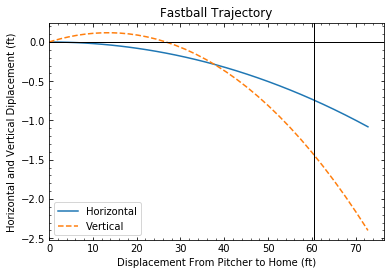

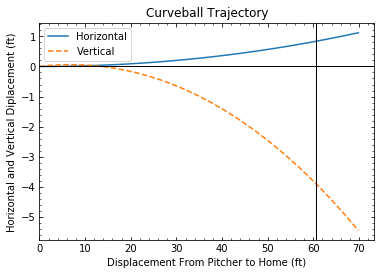

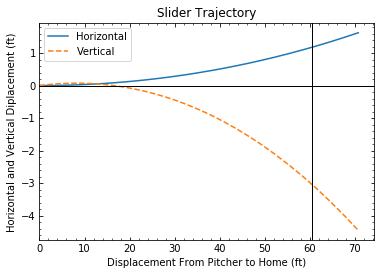

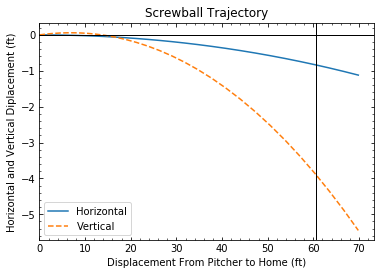

In [5]:
#Construct variables
angle = 1 #deg

spin = 1800 #rpm

v0_fast = 95 #mph
v0_nonfast = 85

orient_fast = 225 #deg 
orient_curve = 45
orient_slide = 0
orient_screw = 135

#Calculate trajectory
traj_fast = trajectory(v0_fast, angle, spin, orient_fast)
traj_curve = trajectory(v0_nonfast, angle, spin, orient_curve)
traj_slide = trajectory(v0_nonfast, angle, spin, orient_slide)
traj_screw = trajectory(v0_nonfast, angle, spin, orient_screw)

#Perform analysis and plots
analysis(traj_fast, "Fastball")
analysis(traj_curve, "Curveball")
analysis(traj_slide, "Slider")
analysis(traj_screw, "Screwball")

## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.

mrb175
<br>
kls188
<br>
gps32